In [ ]:
%load_ext autoreload
%autoreload 2 


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from aux_functions import put_gaze_annotation, rgb,angle_to_2d,is_accurate, plot_metrics
from datasets import MPIIFaceGaze
from random import randint

# Tarea a resolver:

- Se desea predecir el ángulo de la mirada de un individuo a partir de una foto de su cara.
- Para eso se utilizará el dataset de MPIIFaceGaze. [Link aqui](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    - El dataset consiste en imágenes de caras de 15 individuos distintos, mirando a diferentes lugares.
    - Se tienen 3000 imágenes por individuo con sus labels de pitch (ángulo vertical) y yaw (ángulo horizontal).
    - Las imágenes se tomaron de usuarios utilizando sus laptops durante 3 meses. 

# 0. Configuraciones

Configuraciones para CUDA

In [ ]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

# 1. Análisis de datos

En esta sección se analizan los siguientes aspectos del dataset:
1. Cantidad de imágenes y participantes
1.  Distribución de los ángulos de mirada en el dataset.

- El dataset se encuentra en un archivo con formato h5 localizado en la carpeta "datasets"

## 1.1. Cantidad de imágenes

In [ ]:
with h5py.File('./datasets/MPIIFaceGaze.h5', 'r') as file:

    cant_imagenes = 0
    cant_imagenes_persona = []
    gaze_data = []

    for person_idx in range(len(file)):

        person = f"p{person_idx:02d}"
        dataset = file[person]

        images = dataset["image"]
        gaze = dataset["gaze"]
        pose = dataset["pose"]

        cant_imagenes += len(images)
        cant_imagenes_persona.append(len(images))

        # Almaceno todos los labels de miradas [pitch,yaw] del participante
        for i,g in enumerate(gaze):
            i_key = f"{i:04d}"
            gaze_data.append(np.array(gaze[i_key],dtype=float))

print(f"En el dataset hay: {cant_imagenes} imágenes de {len(cant_imagenes_persona)} personas.")
print(f"Las imágenes por persona son: {cant_imagenes_persona}")

Vemos que hay 3000 imágenes por cada persona y se tienen 15 sujetos diferentes. Veamos ahora la distribución de los ángulos de la mirada:

## 1.2. Distribución de ángulos de las miradas

En el dataset los ángulos de la mirada están representados por dos valores, pitch y yaw. Estos representan la rotación horizontal y vertical

En la siguiente imágen se ilustran los ángulos:

![head_ref.png](head_ref.png)

Se analizará la distribución entonces de:

- Pitch: Componente asociada al movimiento vertical.
- Yaw: Componente asociada al movimiento horizontal.
- Angle_2d: Proyección del ángulo en 2 dimensiones (para más información ver el archivo aux_functions.py)

In [ ]:
gaze_array = np.array(gaze_data)
pitch_array = gaze_array[:,0]
yaw_array = gaze_array[:,1]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

In [ ]:
pitch_array_deg = np.rad2deg(pitch_array*np.pi)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

In [ ]:
yaw_array_deg = np.rad2deg(yaw_array*np.pi)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

In [ ]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

In [ ]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribución conjunta de pitch y yaw



In [ ]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Preparación del dataset

- Para facilitar la carga de datos a pytorch se crea una clase que se hereda de torch.utils.Dataset. El código asociado se encuentra en el archivo _datasets.py_

In [ ]:
from datasets import MPIIFaceGaze

In [ ]:
# Selecciono pocas imágenes, solo para probar la que la clase funcione bien 
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=3)
print(f"Se cargaron {len(ds)} imagenes")

In [ ]:
plt.imshow(ds.images_list[20][:,:,::-1])

## 2.1 Data augmentation

In [ ]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
])


In [ ]:
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=350)
print(f"Se cargaron {len(ds)} imagenes")

Ahora se separará el set en entrenamiento y testeo y luego se visualizarán las transformaciones

## 2.2 Creación de los set de entrenamiento y testeo

- Al usar resnet18 como capas previas (para aprovechar y hacer transfer learning), las imagenes deben ser redimensionadas a 224x224
- Data augmentation:
    - RandomResizedCrop: Se busca cortar y redimensionar la imagen aleatoreamente para generar más diversidad de datos
    - ColorJitter: Se realizan leves cambios en la saturación y el tono para garantizar más robustez ante distintas varaciones lumínicas y de color de ojos
    - No se pueden realizar transformaciones como HorizontalFlip o VerticalFlip porque alteran la posición de la mirada.

In [ ]:
# Separo en entrenamiento y validacion (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [ ]:
# Obtengo una imagen para visualizar las transformaciones
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Graficamos la imagen junto con el label para asegurarnos que esté bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

# 3. Modelos

Se probarán los siguientes modelos:

- Modelo _custom_: red neuronal hecha desde cero, con capas convolucionales y fully connected.

- Modelo basado en ResNet18:
    - Transfer Learning a partir de una ResNet 18.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

- Modelo basado en ResNet34:
    - Transfer Learning a partir de una ResNet 34.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

In [125]:
from models import GazeEstimation_ResNet18, GazeEstimation_ResNet34, CNN_custom
from torchsummary import summary


## 3.1 Red CNN propia

### 3.1.1 Instanciación

In [126]:
# Instanciación del modelo con una red CNN propia
model_cnn_propia = CNN_custom(name="cnn_propia")
model_cnn_propia.dynamic_lr = False
model_cnn_propia.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_cnn_propia.parameters(), lr=1e-5)

#Summary
summary(model_cnn_propia.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,216
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
         Dropout2d-9           [-1, 32, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          18,496
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
        MaxPool2d-13           [-1, 64, 28, 28]               0
        Dropout2d-14           [-1, 64,

### 3.1.2. Entrenamiento

In [127]:
model_cnn_propia.fit(train_loader, val_loader, criterion, optimizer, epochs=2, device=device, save_model=True)

Epoch 1/2


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss 0.03402: 100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0995 / 13.32% | Validation Loss / Accuracy: 0.0340 / 21.05%
Epoch 2/2


Validation loss 0.02928: 100%|██████████| 22/22 [00:11<00:00,  1.96it/s]

Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0739 / 13.17% | Validation Loss / Accuracy: 0.0293 / 18.73%


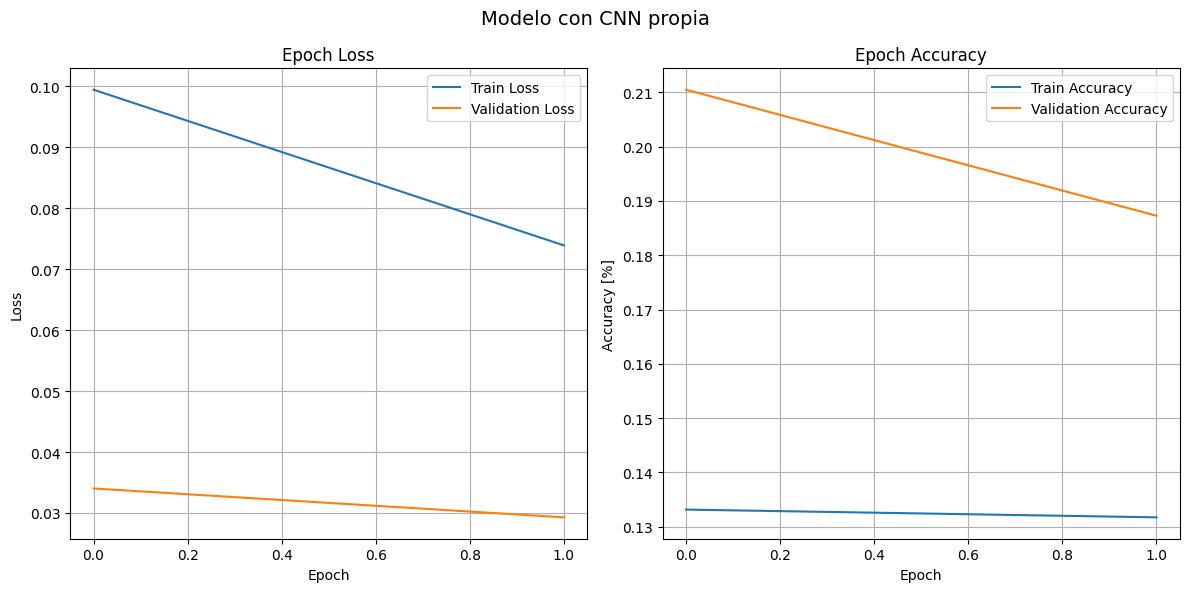

In [128]:
plot_metrics(model_cnn_propia,title="Modelo con CNN propia")

In [129]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = CNN_custom()
new_model.load_state_dict(torch.load('./modelos/cnn_propia.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device)
outputs = new_model(inputs)

print(outputs)

tensor([[-0.2328, -0.0724],
        [ 0.0232,  0.1550],
        [-0.0944, -0.1020],
        [ 0.0315,  0.3546],
        [-0.3789, -0.2224],
        [-0.0746, -0.2061],
        [-0.3374,  0.2168],
        [ 0.1703, -0.0235]], device='cuda:0', grad_fn=<AddmmBackward0>)


/tmp/ipykernel_1932945/2492880537.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/cnn_propia.pth'))


## 3.2 Red basada en ResNet18

### 3.2.1. Instanciación

In [130]:
# Instanciación del modelo con resnet18
model_resnet18 = GazeEstimation_ResNet18(name="resnet18",pretrained=True) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet18.dynamic_lr = False
model_resnet18.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.2.2. Entrenamiento

In [131]:
model_resnet18.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/2


Validation loss 0.02345: 100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0358 / 14.22% | Validation Loss / Accuracy: 0.0235 / 19.01%
Epoch 2/2


Validation loss 0.02144: 100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0239 / 19.35% | Validation Loss / Accuracy: 0.0214 / 19.48%


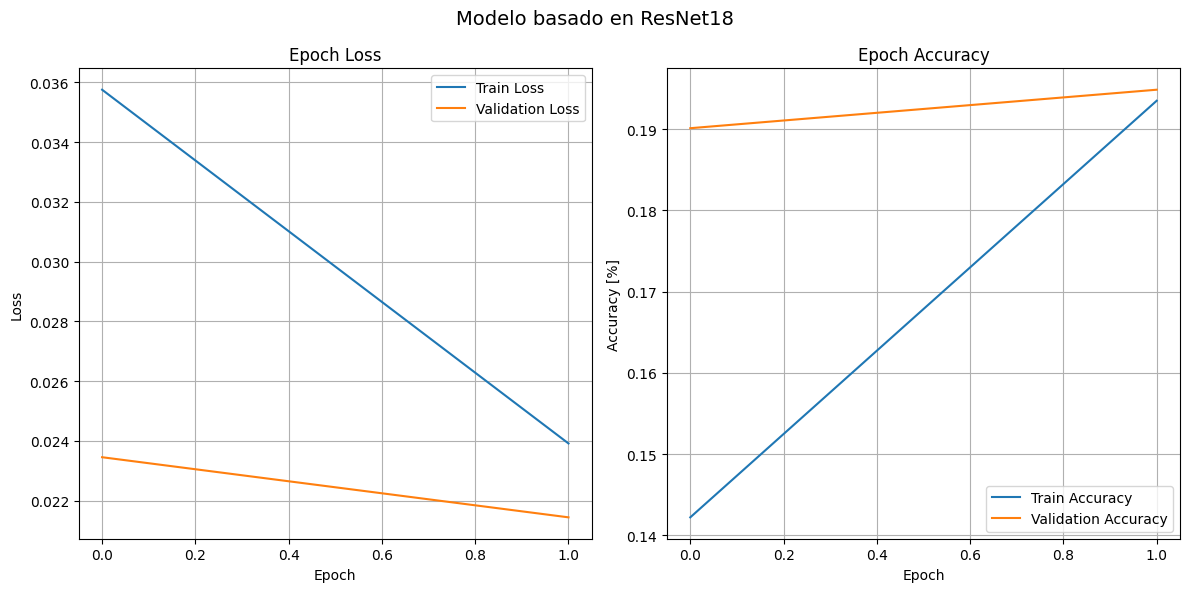

In [132]:
plot_metrics(model_resnet18,title="Modelo basado en ResNet18")

In [133]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet18()
new_model.load_state_dict(torch.load('./modelos/resnet18.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device) 
outputs = new_model(inputs) 

print(outputs)

/tmp/ipykernel_1932945/3045565910.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/resnet18.pth'))


tensor([[-0.2696,  0.0670],
        [-0.2521, -0.0393],
        [-0.1931, -0.0077],
        [-0.1168, -0.0349],
        [-0.1682,  0.0696],
        [-0.1678,  0.0124],
        [-0.1034,  0.0224],
        [-0.2480, -0.0226]], device='cuda:0', grad_fn=<AddmmBackward0>)


## 3.3 Modelo basado en ResNet34

### 3.3.1 Instanciación

In [135]:
# Instanciación del modelo con resnet34
model_resnet34 = GazeEstimation_ResNet34(name="resnet34",pretrained=True,debug=False) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet34.dynamic_lr = False
model_resnet34.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet34.to(device), input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/idk/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 66.7MB/s]


resnet34.conv1.weight: No entrenable
resnet34.bn1.weight: No entrenable
resnet34.bn1.bias: No entrenable
resnet34.layer1.0.conv1.weight: No entrenable
resnet34.layer1.0.bn1.weight: No entrenable
resnet34.layer1.0.bn1.bias: No entrenable
resnet34.layer1.0.conv2.weight: No entrenable
resnet34.layer1.0.bn2.weight: No entrenable
resnet34.layer1.0.bn2.bias: No entrenable
resnet34.layer1.1.conv1.weight: No entrenable
resnet34.layer1.1.bn1.weight: No entrenable
resnet34.layer1.1.bn1.bias: No entrenable
resnet34.layer1.1.conv2.weight: No entrenable
resnet34.layer1.1.bn2.weight: No entrenable
resnet34.layer1.1.bn2.bias: No entrenable
resnet34.layer1.2.conv1.weight: No entrenable
resnet34.layer1.2.bn1.weight: No entrenable
resnet34.layer1.2.bn1.bias: No entrenable
resnet34.layer1.2.conv2.weight: No entrenable
resnet34.layer1.2.bn2.weight: No entrenable
resnet34.layer1.2.bn2.bias: No entrenable
resnet34.layer2.0.conv1.weight: Entrenable
resnet34.layer2.0.bn1.weight: Entrenable
resnet34.layer2.0.b

### 3.3.2 Entrenamiento

In [136]:
model_resnet34.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/2


Validation loss 0.07404: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0809 / 0.19% | Validation Loss / Accuracy: 0.0740 / 0.07%
Epoch 2/2


Validation loss 0.07596: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]

[Lr:1e-05] Training Loss / Accuracy: 0.0809 / 0.28% | Validation Loss / Accuracy: 0.0760 / 0.07%


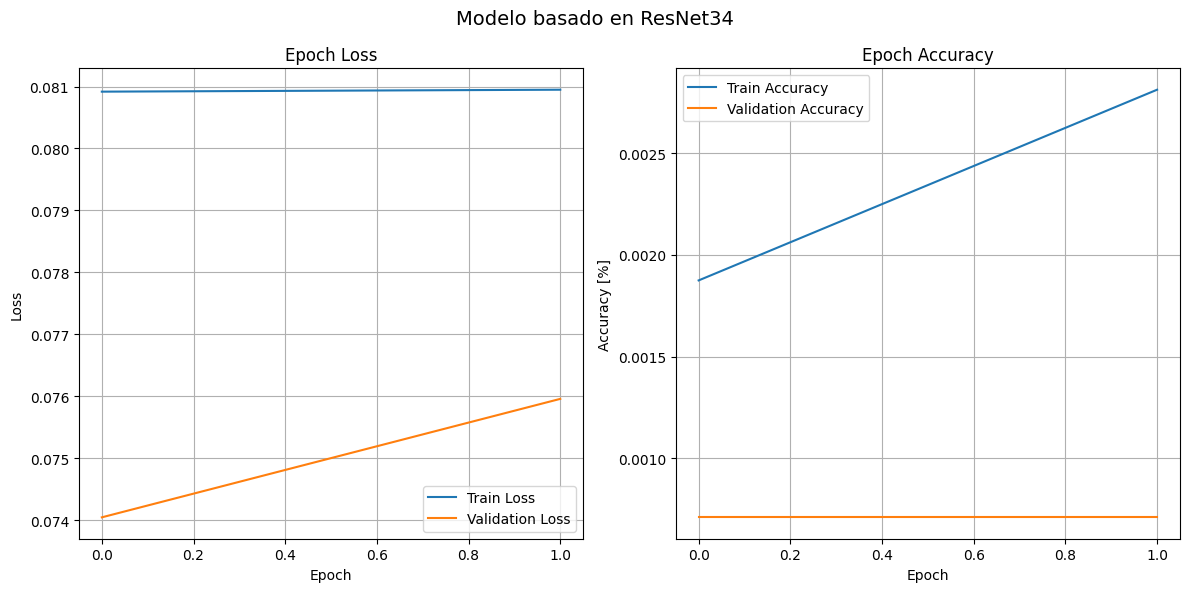

In [137]:
plot_metrics(model_resnet34,title="Modelo basado en ResNet34")

In [139]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet34()
new_model.load_state_dict(torch.load('./modelos/resnet34.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device) 
outputs = new_model(inputs) 

print(outputs)

/tmp/ipykernel_1932945/1033572697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/resnet34.pth'))


tensor([[ 0.2229,  0.1363],
        [ 0.0855, -0.0388],
        [ 0.1142,  0.0791],
        [ 0.0707,  0.0478],
        [ 0.0856, -0.0056],
        [ 0.0698,  0.1188],
        [ 0.1156,  0.1323],
        [ 0.1575,  0.2050]], device='cuda:0', grad_fn=<AddmmBackward0>)


## 3.4 Validación

Se toma una imagen al azar y se visualiza la dirección de la mirada actual VS la predicha
- Flecha azul: indica la posición de la mirada verdadera.
- Flecha verde: indica la posición de la mirada predicha por el modelo.

In [ ]:
# Se elige el modelo a probar
model = model_resnet18

# Se elige imagen al azar y se obtienen sus labesl (pitch,yaw)
img, gaze = test_dataset[randint(0,len(test_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Ahora se pasa la imagen por el modelo y se obtiene la predicción
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Se define la tolerancia para considerar una predicción como precisa o no 
tolerancia = 15 # 15° de tolerancia para considerar una predicción como error
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Impresión de parámetros
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Se agregan anotaciones a la imagen
img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicho",label_y=22) #Prediced: flecha verde
img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: flecha azul

# Mostrar imagen (se convierte a RGB porque openCV trabaja en BGR)
plt.imshow(rgb(img))

## 3.5 Visualización de métricas en Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

## 4. Ajuste de hiperparámetros

Se busca responder la siguiente consigna del TP: 

> Entrenamientos realizados (al menos 4). Hiperparametros utilizados en cada uno.

- Instanciar el modelo con diferentes nombres asi se guardan distintos modelos en TensorBoard y es más fácil comparar
